# Script for displaying simulation data
This script is made to easily display simulation data

In [20]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from openpyxl import Workbook, load_workbook
import os

#Finding excel file and working dir
workbookFile = "SimulationRuns02042025.xlsx"
workingDir = os.getcwd().replace("DataDisplay","")
print(workingDir)

#Function to somewhat clean up the spiking action going on at the walls, only used for velocity
def cleanSpikes(velocity):
    newz = []
    for i,coord in enumerate(velocity):
        if(i==0):
            newz.append(coord)
            continue
        if((coord-newz[-1]) > 0.07 or (coord-newz[-1]) < -0.07):
            newz.append(0)
        else: newz.append(coord)
    return newz

#Data class, which holds all info about the data which is gotten automatically from the excel file
def Data(studentName:str,cellRow:int):
    filePath = ""
    simulationParams = {}
    workbook = load_workbook(workingDir+"DataDisplay\\"+workbookFile)
    sheet = workbook.active
    filePath = workingDir + "SimulationData\\"+ studentName.capitalize()+ "\\" + sheet[f'A{cellRow}'].value
    #Iterate over all colums and gather data about simulation parameters
    for i in ["B","C","D","E","F","G","H","I"]:
        simulationParams[((sheet[f'{i}1'].value).lower()).replace(" ","_")] = sheet[f'{i}{cellRow}'].value
    table = None
    try:
        table = pd.read_csv(filePath,delimiter=" ",header=None,names=["Z","D","V","T"])
    except:
        print(f'File {filePath} probably not found, irregardless there is no pandas table...')
    # We only want the data within the walls, so we exclude all other data (and move it down so it starts at 0)
    # We find the walls using the density plot, if the density is above 0.01, we consider it within the bounds of the wall.
    wall_mask = table["D"] > 0.01
    table["Z"] = table["Z"][wall_mask]
    table["D"] = table["D"][wall_mask]
    table["V"] = table["V"][wall_mask]
    table["T"] = table["T"][wall_mask]

    table["Z"] =  table["Z"] - table["Z"].min()
    return {"filePath":filePath,"simulationParams":simulationParams,"table":table}
    

def getSeveralSims(studentName:str, rows:list=[],rowRange:list=[]):
    data = []
    if len(rows) == 0 and len(rowRange)==0:
        print("No rows or range given, cannot return data.")
        return
    elif len(rows) > 0 and len(rowRange) > 0:
        print("Row and range both specified, cannot get data as I do not know which one to trust.")
        return
    elif len(rows) > 0 and len(rowRange) == 0:
        print(f'Getting data from rows: {rows}')
        for i in rows:
            data.append(Data(studentName,i))
        return data
    elif len(rowRange) == 2 and len(rows) == 0:
        print(f'Getting data from range, from row {rowRange[0]} to {rowRange[1]}, inclusive')
        for i in range(rowRange[0],rowRange[1]+1):
            data.append(Data(studentName,i))
        return data
    elif len(rowRange) > 2:
        print("Range cannot include more than 2 numbers.")

c:\Users\Thea-\Documents\Python\MathPhyscisSubjectModuleProject\


In [7]:
#Here we store functions to make the theoretical model

#Boltzmann constant, we need this?
kB = 1.38*(10**(-23))

def parabola(x,a,b,c):
    return x**2*a+x*b+c

def momentumPFlowEquation(y,rho,mu,P,A,B):
    return y**2/(rho*mu*2)*P-y*A-B

def dirichletSlip(slip,channel_width,rho,mu,P):
    A = channel_width/(rho*mu*2)*P
    B = -slip
    return A,B

def neumannSlip(Ls,channel_width,rho,mu,P):
    A = (P*channel_width)/(rho*mu*2)
    B = Ls*A
    return A,B

def findSlipLength(simulationData,force_b=-1):
    dudxs = []
    for i in range(0,np.sum(simulationData["table"]["Z"] < simulationData["simulationParams"]["width_of_channel"]/10)):
        dudx = simulationData["table"]["V"][i+2]-simulationData["table"]["V"][i]
        if(dudx > 0 and simulationData["table"]["V"][i] > 0 and simulationData["table"]["V"][i+2] > 0):
            dudxs.append(dudx/(simulationData["table"]["Z"][i+2]-simulationData["table"]["Z"][i]))
    a = np.mean(dudxs)
    maskL = simulationData["table"]["Z"] > 0
    maskU = simulationData["table"]["Z"][maskL] < 0.1
    b = np.mean(simulationData["table"]["V"][maskL][maskU])
    if(force_b>=0):
        b=force_b
    L_s = -b/a
    return np.abs(L_s),a,b

def findSlipLengthCF(simulationData,estimate_center,estimate_B):
    maskL = simulationData["table"]["Z"] > 0
    vars,cov=curve_fit(parabola,simulationData["table"]["Z"][maskL],simulationData["table"]["V"][maskL],[-1/(2*estimate_center),-estimate_center*2,estimate_B],absolute_sigma=True)
    L_s = -vars[2]/vars[1]
    return np.abs(L_s),vars[0],vars[1],vars[2],cov
        
    

cw = 10
Y = np.linspace(0,10)
A,B= neumannSlip(1,cw,1,1,-1)

# plt.plot(Y,momentumPFlowEquation(Y,1,1,-1,A,B))

Getting data from range, from row 6 to 11, inclusive
Quality of curve fit: 31484.357564345533


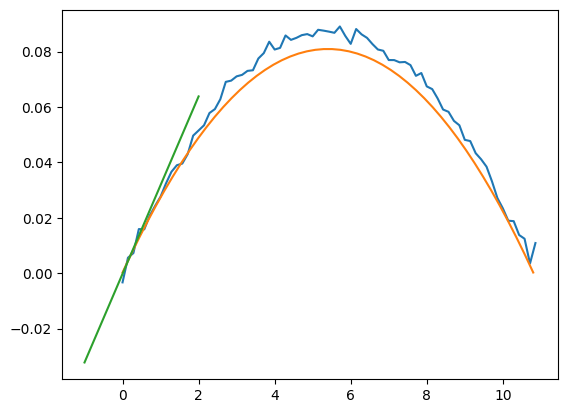

In [18]:
#Set your default simulation (meaning the simulation you have run where all variables are "default" for you)
#For me it is T1 at row 5
default = Data("Thea",5)

#I get all my sims, luckily they are right next to eachother in the excel sheet
sims = getSeveralSims("Thea",rowRange=[6,6+5])

#Testing slip length estimation:
data = sims[0]

# L_s,a,b = findSlipLength(data,0)
L_s,a,b,c,cov = findSlipLengthCF(data,6,0)

print(f'Quality of curve fit: {np.linalg.cond(cov)}')

Z = data["table"]["Z"]
min = np.min(Z)
Y = np.linspace(0,data["simulationParams"]["width_of_channel"]*1.20)
plt.plot(Z,data["table"]["V"])
A,B = neumannSlip(L_s,data["simulationParams"]["width_of_channel"]*1.20,data["simulationParams"]["density_fluid"],2.58,-0.01)
plt.plot(Y,momentumPFlowEquation(Y,data["simulationParams"]["density_fluid"],2.58,-0.01,A,B))
X = np.linspace(-1,2)
plt.plot(X,X*b+c)
#End of testing slip length estimation

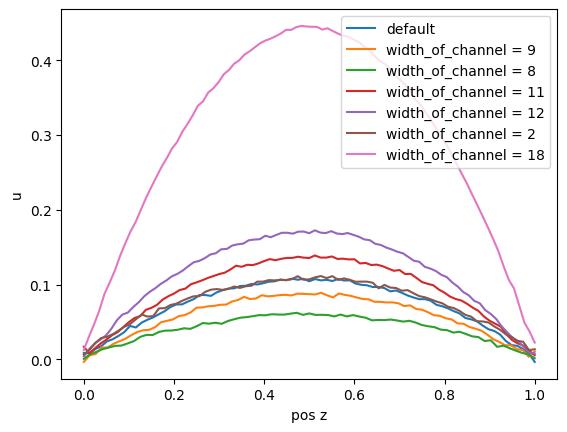

In [19]:
#Function purely to not have to look at this exact code over and over again
def plotInFigure(sim:dict,label:str,plottype:str,default:dict=None):
    table = sim["table"]
    plt.plot(table["Z"]/table["Z"].max(),table[plottype],label=label)

#We now make the plotting function
#Plottype is either "D" density, "V" streaming velocity or "T" temperature
def getLabel(sim:Data,default:Data):
    simName = ""
    #We figure out how the simulation is different from the default, we use this for telling them apart in naming and labels
    for key,value in sim["simulationParams"].items():
        #We ignore any discrepencies in timeblocks and steps per timeblock as we arent really interested in what happens when we vary them
        if key == "timeblocks" or key == "steps_per_timeblock":
            continue
        if value != default["simulationParams"][key]:
            simName = f'{key} = {value}'
    return simName



#Makes a plot for every sim I have gotten earlier
plt.plot(default["table"]["Z"]/default["table"]["Z"].max(),default["table"]["V"],label="default")
for i in range(len(sims)):
    data = sims[i]["table"]
    plt.plot(data["Z"]/data["Z"].max(),data["V"],label=getLabel(sims[i],default))

plt.xlabel("pos z")
plt.ylabel("u")

plt.legend()
plt.show()

